### Basic architecture
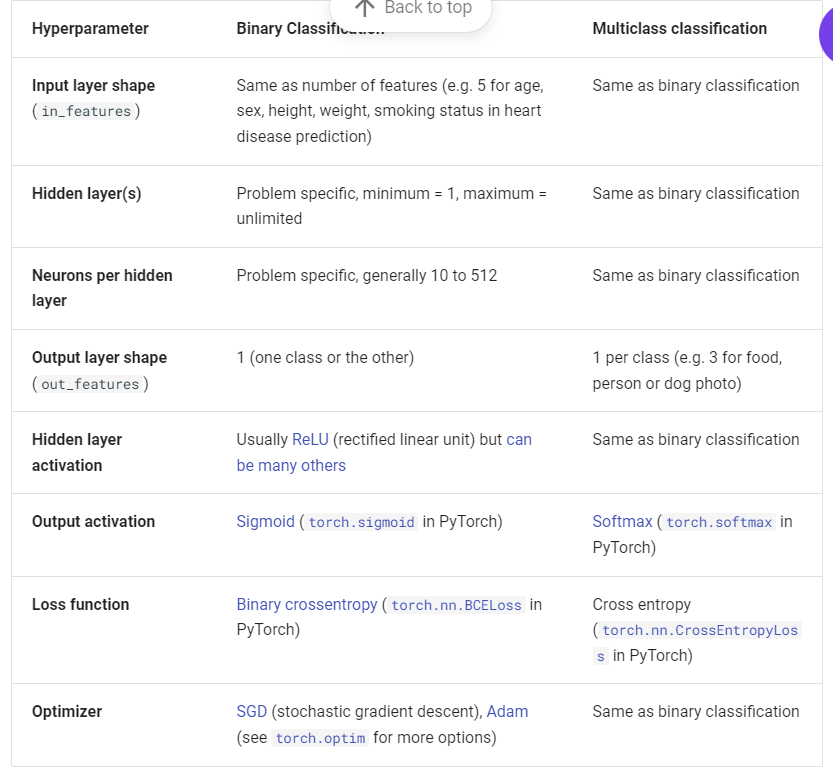

### 1. getting data ready

In [1]:
from sklearn.datasets import make_circles

n_samples = 1000
X,y = make_circles(n_samples,noise=0.03,random_state = 42)

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
import pandas as pd
circles = pd.DataFrame(
    {
        "X1":X[:,0],
        "X2":X[:,1],
        "label":y
    }
)
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
#so now we have a basic classification problem data
circles.label.value_counts()

,count
label,
1,500
0,500


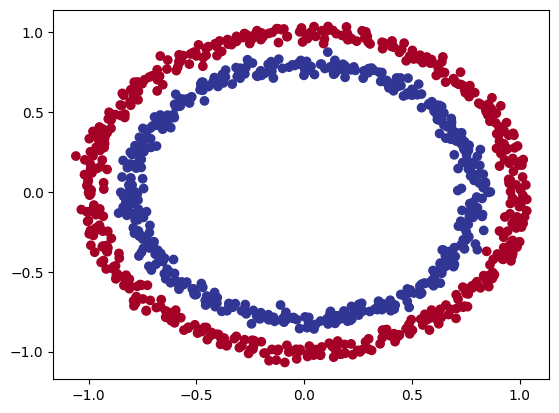

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);
    #so this becomes our binary classification where we predict either red or blue

#### 1.1 input and output shapes

In [6]:
X.shape,y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")
#so we can say that 2nd one is scalar and 1st one is vector

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


#### 1.2 turn into tensors and do train test split

In [8]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 2. Build the model

In [10]:
#the basic one
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
#now model implementation using subclassing the nn.module
from torch import nn
class model(nn.Module):#always subclass the module and do and put forwar
  def __init__(self):
    super().__init__()
    #we need to create 2 layers say
    self.layer1 = nn.Linear(in_features=2,out_features=5)#because 2 input we have x1 and x2 and create a hidden layer with 5 neurons
    self.layer2 = nn.Linear(in_features = 5,out_features = 1)#as binary classification we do 1 as output

  def forward(self,x):
    #so forward shd tell what we do with the input x so bascially we put to layer1 then to 2
    return self.layer2(self.layer1(x))

In [12]:
model_0 = model().to(device)#put to device
model_0

model(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
#we can do the same using the sequential also
model_0 = nn.Sequential(
    nn.Linear(in_features = 2,out_features =5),
    nn.Linear(in_features = 5,out_features =1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
'''
nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.
'''

"\nnn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.\n\nSo if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.\n"

In [15]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))#as model is in device
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.3412],
        [-0.2773],
        [-0.6472],
        [-0.2539],
        [-0.8673],
        [-0.8266],
        [-0.4724],
        [-0.6016],
        [-0.6375],
        [-0.2754]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#### 2.1 Setup loss function and optimizer

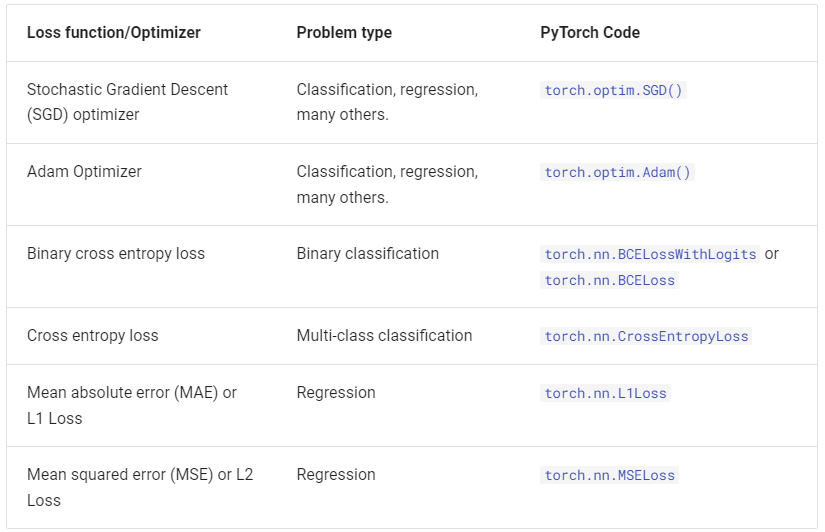

In [16]:
'''
PyTorch has two binary cross entropy implementations:

torch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
torch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).
Which one should you use?

The documentation for torch.nn.BCEWithLogitsLoss() states that it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of nn.Sigmoid and torch.nn.BCELoss() but that is beyond the scope of this notebook.
'''

"\nPyTorch has two binary cross entropy implementations:\n\ntorch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).\ntorch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).\nWhich one should you use?\n\nThe documentation for torch.nn.BCEWithLogitsLoss() states that it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.\n\nSo generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of nn.Sigmoid and torch.nn.BCELoss() but that is beyond the scope of this notebook.\n"

In [17]:
loss_fn = nn.BCEWithLogitsLoss()#better than jus BCELoss has sigmoid builtin

optimizer = torch.optim.SGD(params = model_0.parameters(),lr=0.01)

In [18]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

### 3.Train the model

#### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [19]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3412],
        [-0.2773],
        [-0.6472],
        [-0.2539],
        [-0.8673]], grad_fn=<SliceBackward0>)

In [20]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4155],
        [0.4311],
        [0.3436],
        [0.4369],
        [0.2958]], grad_fn=<SigmoidBackward0>)

In [21]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [22]:
y_test[:5]#this is the real one

tensor([1., 0., 1., 0., 1.])

In [23]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits(IMP)
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.74108, Accuracy: 50.00% | Test loss: 0.74441, Test acc: 50.00%
Epoch: 10 | Loss: 0.73546, Accuracy: 50.00% | Test loss: 0.73917, Test acc: 50.00%
Epoch: 20 | Loss: 0.73051, Accuracy: 50.00% | Test loss: 0.73457, Test acc: 50.00%
Epoch: 30 | Loss: 0.72617, Accuracy: 50.00% | Test loss: 0.73055, Test acc: 50.00%
Epoch: 40 | Loss: 0.72235, Accuracy: 50.00% | Test loss: 0.72702, Test acc: 50.00%
Epoch: 50 | Loss: 0.71900, Accuracy: 50.00% | Test loss: 0.72393, Test acc: 50.00%
Epoch: 60 | Loss: 0.71606, Accuracy: 50.00% | Test loss: 0.72122, Test acc: 50.00%
Epoch: 70 | Loss: 0.71347, Accuracy: 50.00% | Test loss: 0.71885, Test acc: 50.00%
Epoch: 80 | Loss: 0.71120, Accuracy: 50.00% | Test loss: 0.71678, Test acc: 50.00%
Epoch: 90 | Loss: 0.70921, Accuracy: 50.00% | Test loss: 0.71497, Test acc: 50.00%


In [24]:
#getting not so good predictions so to see what is happening we visualize

### 4. Make predictions and evaluate the model

In [25]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

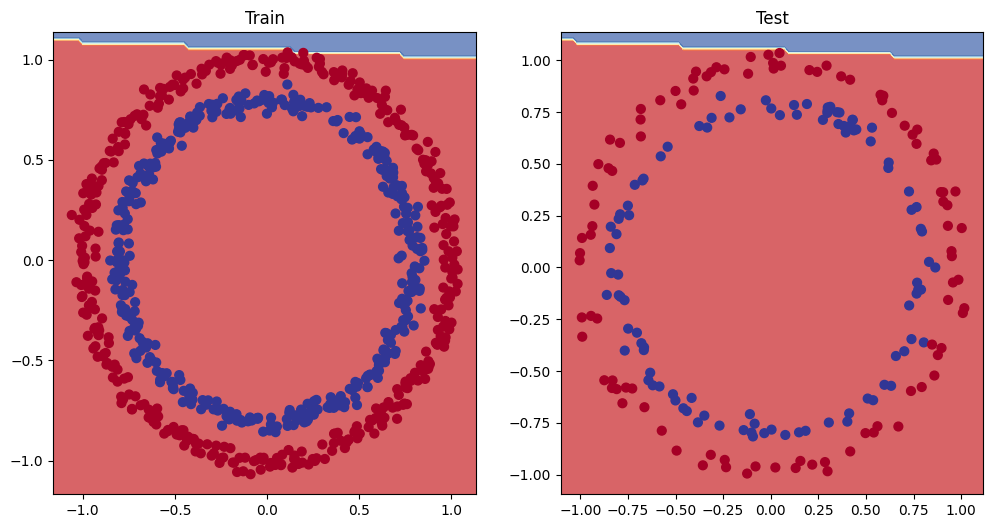

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [27]:
'''
Oh wow, it seems like we've found the cause of model's performance issue.

It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.
'''

"\nOh wow, it seems like we've found the cause of model's performance issue.\n\nIt's currently trying to split the red and blue dots using a straight line...\n\nThat explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.\n\nIn machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.\n"

### 5. improving the model

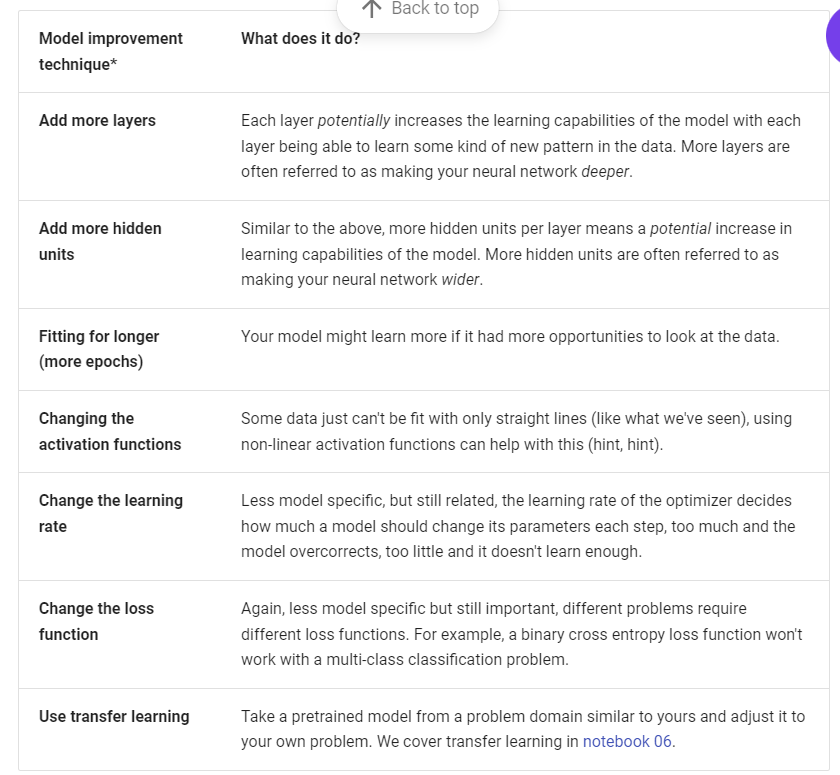

In [31]:
#so increase units,epochs,layers
class model_1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2,out_features=10)
    self.layer2 = nn.Linear(in_features = 10,out_features = 10)
    self.layer3 = nn.Linear(in_features = 10,out_features =1)

  def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer3(self.layer2(self.layer1(x)))

model_1 = model_1().to(device)
model_1

model_1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
loss_fn = nn.BCEWithLogitsLoss()#better than jus BCELoss has sigmoid builtin

optimizer = torch.optim.SGD(params = model_1.parameters(),lr=0.01)

In [33]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69369, Accuracy: 50.25% | Test loss: 0.69269, Test acc: 50.00%
Epoch: 200 | Loss: 0.69351, Accuracy: 50.12% | Test loss: 0.69282, Test acc: 49.50%
Epoch: 300 | Loss: 0.69339, Accuracy: 50.50% | Test loss: 0.69295, Test acc: 49.00%
Epoch: 400 | Loss: 0.69329, Accuracy: 50.38% | Test loss: 0.69309, Test acc: 48.50%
Epoch: 500 | Loss: 0.69322, Accuracy: 49.88% | Test loss: 0.69322, Test acc: 49.50%
Epoch: 600 | Loss: 0.69317, Accuracy: 49.50% | Test loss: 0.69335, Test acc: 53.00%
Epoch: 700 | Loss: 0.69313, Accuracy: 49.38% | Test loss: 0.69347, Test acc: 50.50%
Epoch: 800 | Loss: 0.69309, Accuracy: 50.00% | Test loss: 0.69358, Test acc: 51.00%
Epoch: 900 | Loss: 0.69307, Accuracy: 50.62% | Test loss: 0.69368, Test acc: 47.50%


In [34]:
'''
What? Our model trained for longer and with an extra layer but it still looks
like it didn't learn any patterns better than random guessing.

Let's visualize.
'''

"\nWhat? Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing.\n\nLet's visualize.\n"

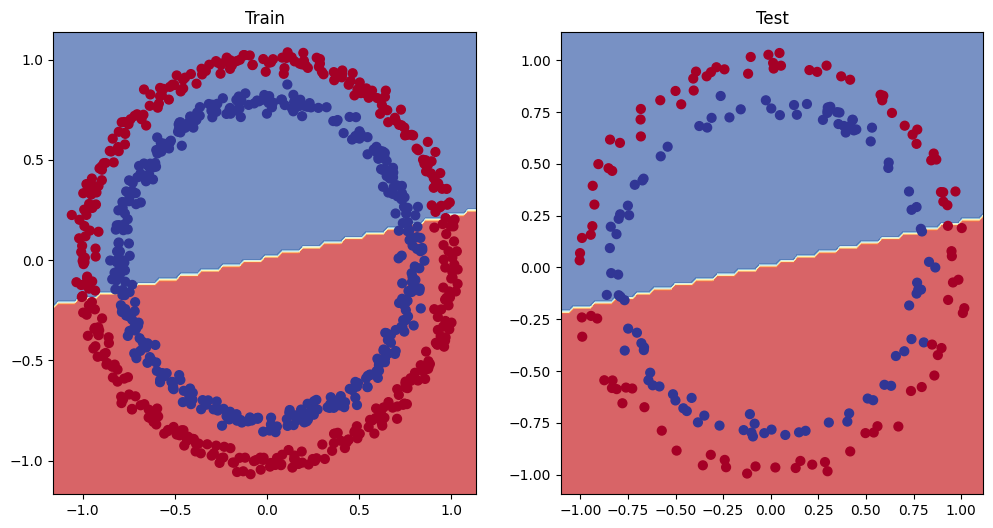

In [35]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [36]:
#so still it is modelling a straight line so we can try the notebook 1 linear
#regression on it and it will model well so it has abitlity to learn

### 6. The missing piece: non-linearity

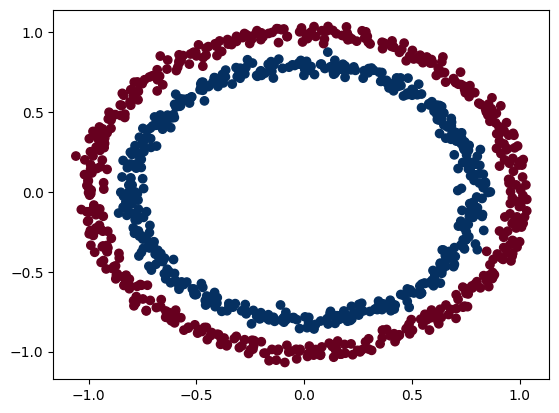

In [37]:
#do the data again
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [38]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [41]:
#so now building model with non-linearity(so use activation functions)
class model_2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2,out_features=10)
    self.layer2 = nn.Linear(in_features = 10,out_features =10)
    self.layer3 = nn.Linear(in_features = 10,out_features =1)
    self.relu = nn.ReLU()
    #so here we define all the layers and all and in forward we make how they are
    #connected like the actual network
  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    #so output to relu and like that the last output we dint do we could also
    #with sigmoid adding but use of loss function which has that we are using
    #so no problem

model_2 = model_2().to(device)
model_2

model_2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [42]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [43]:
#now train the model
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_2(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70683, Accuracy: 50.00% | Test Loss: 0.70463, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69301, Accuracy: 49.75% | Test Loss: 0.69122, Test Accuracy: 54.00%
Epoch: 200 | Loss: 0.69129, Accuracy: 50.75% | Test Loss: 0.68961, Test Accuracy: 56.00%
Epoch: 300 | Loss: 0.68996, Accuracy: 51.38% | Test Loss: 0.68847, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68842, Accuracy: 52.50% | Test Loss: 0.68704, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68640, Accuracy: 52.62% | Test Loss: 0.68518, Test Accuracy: 55.50%
Epoch: 600 | Loss: 0.68360, Accuracy: 53.37% | Test Loss: 0.68279, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.67949, Accuracy: 61.88% | Test Loss: 0.67972, Test Accuracy: 61.00%
Epoch: 800 | Loss: 0.67328, Accuracy: 63.88% | Test Loss: 0.67545, Test Accuracy: 58.50%
Epoch: 900 | Loss: 0.66395, Accuracy: 66.88% | Test Loss: 0.66929, Test Accuracy: 61.00%


In [44]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

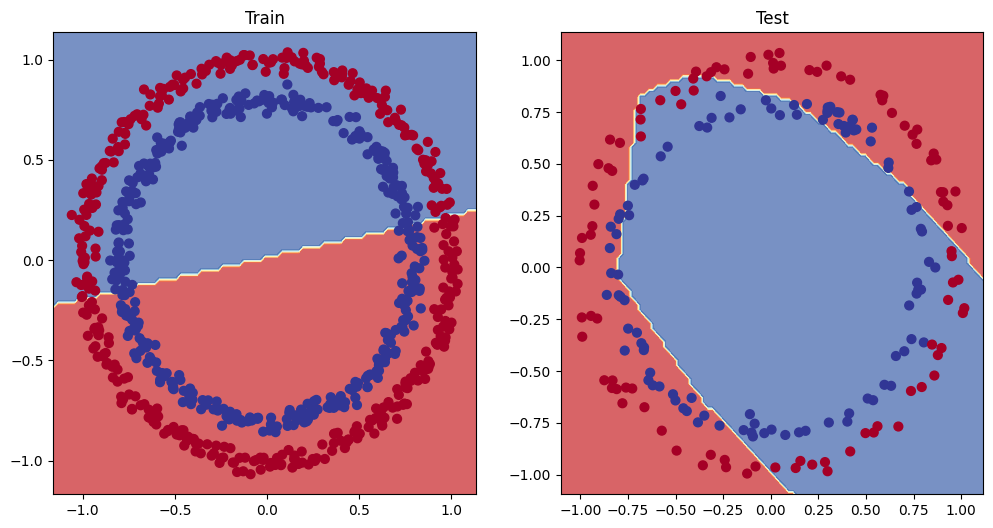

In [46]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test) # model_2 = has non-linearity

In [47]:
#see notebook to understand the good plots of all activation functions

### 8. Putting things together by building a multi-class PyTorch model

#### 8.1 Creating multi-class classification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


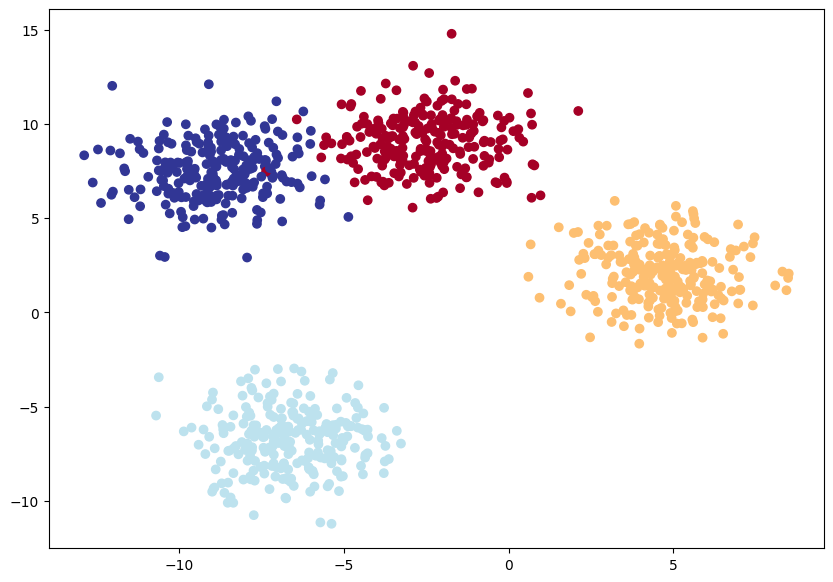

In [48]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [49]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [51]:
#new way than just initialize in the class we can do this(also the sequential use)
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
        #our dataset needs non-linear so use of relu is needed
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [52]:
#create a loss function and optimizer
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance
#since it is mulitclass shd use crossEntropyLoss

In [53]:
#so since multiclass shd deal differently the output gives 4 as 4 classes
#so use softmax to get the probabilites and we shd take the argmax

In [54]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.6226, -0.4992,  0.3042, -0.2222],
        [ 0.6736, -1.1873,  0.1842, -0.6871],
        [ 0.2130, -0.9997,  0.3891, -1.0923],
        [ 0.4027, -0.7745,  0.4512, -0.8176],
        [ 0.3791, -1.2052,  0.0704, -0.7173]], grad_fn=<SliceBackward0>)

In [55]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [56]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.7111, -0.5330,  0.3307, -0.2327],
        [-0.3420, -1.7850, -0.3224, -1.1384],
        [ 0.1878, -0.8563,  0.3375, -0.9026],
        [ 0.4513, -0.4277,  0.2498, -0.1940],
        [ 0.8922, -0.9492,  0.3245, -0.5287]], grad_fn=<SliceBackward0>)
tensor([[0.4236, 0.1221, 0.2895, 0.1648],
        [0.3694, 0.0873, 0.3767, 0.1666],
        [0.3509, 0.1235, 0.4076, 0.1179],
        [0.3627, 0.1506, 0.2965, 0.1902],
        [0.5084, 0.0806, 0.2882, 0.1228]], grad_fn=<SliceBackward0>)


In [57]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [58]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.4236, 0.1221, 0.2895, 0.1648], grad_fn=<SelectBackward0>)
tensor(0)


In [59]:
y_blob_test[0]#the actual is

tensor(1)

In [60]:
# so now creating the testing and training loop
torch.manual_seed(42)

epochs = 1000

X_blob_train,y_blob_train = X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs):

  #do Training
  model_4.train()

  #1. forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
  #2. calculate loss and accuracy
  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,y_pred = y_pred)

  #3. optimizer zero grad
  optimizer.zero_grad()

  #4.loss backward
  loss.backward()#so the loss we do what we get from the loss function

  #5.optimzer step
  optimizer.step()

  ###Testing
  model_4.eval()

  with torch.inference_mode():
     # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.37484, Accuracy: 49.38% | Test loss: 1.14556, Test acc: 76.50%
Epoch: 100 | Loss: 0.04761, Accuracy: 98.88% | Test loss: 0.03805, Test acc: 99.00%
Epoch: 200 | Loss: 0.03158, Accuracy: 98.88% | Test loss: 0.02269, Test acc: 99.50%
Epoch: 300 | Loss: 0.02923, Accuracy: 98.88% | Test loss: 0.01936, Test acc: 99.50%
Epoch: 400 | Loss: 0.02820, Accuracy: 99.00% | Test loss: 0.01762, Test acc: 99.50%
Epoch: 500 | Loss: 0.02758, Accuracy: 99.00% | Test loss: 0.01660, Test acc: 99.50%
Epoch: 600 | Loss: 0.02712, Accuracy: 99.00% | Test loss: 0.01585, Test acc: 99.50%
Epoch: 700 | Loss: 0.02672, Accuracy: 99.00% | Test loss: 0.01527, Test acc: 99.50%
Epoch: 800 | Loss: 0.02636, Accuracy: 99.00% | Test loss: 0.01482, Test acc: 99.50%
Epoch: 900 | Loss: 0.02603, Accuracy: 99.12% | Test loss: 0.01439, Test acc: 99.50%


In [61]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ -0.1833,  11.3875,  -4.1626,  -2.2409],
        [ -1.9018, -10.7206,  -9.0210,   5.1990],
        [ -4.7864,  -4.1908,   7.7630,  -3.7219],
        [ -1.3453,   8.2048,  -2.5988,  -1.1323],
        [  9.3135,   2.4663,  -6.6689,  -3.8016],
        [ -2.3901, -12.8905, -10.6209,   6.3575],
        [ -4.6340,  -3.7431,   7.2152,  -3.4605],
        [  8.1306,  -2.3053,  -7.4873,  -1.7425],
        [ -5.7665,  -5.1357,   9.5307,  -4.5198],
        [  8.5358,  -0.7073,  -7.0498,  -2.4763]])

In [62]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


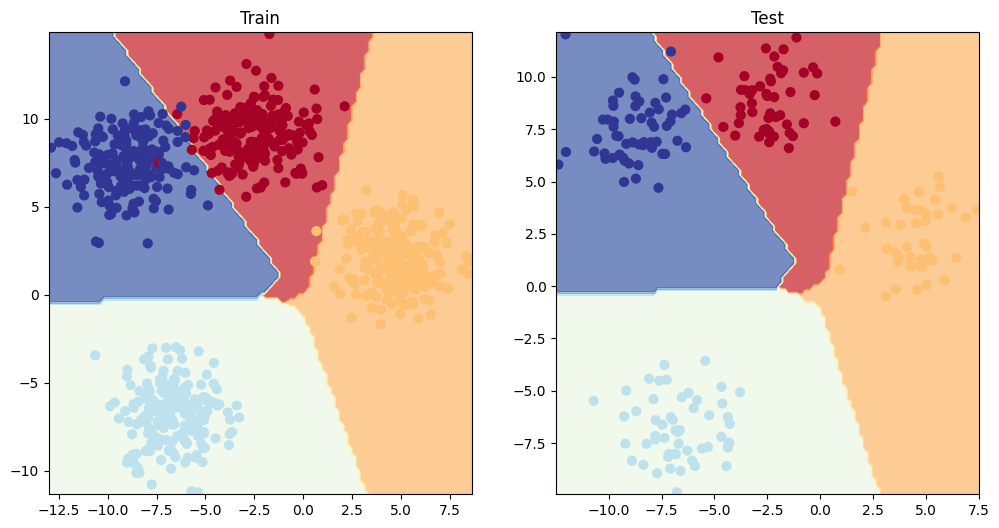

In [63]:
#seeing the decesion boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

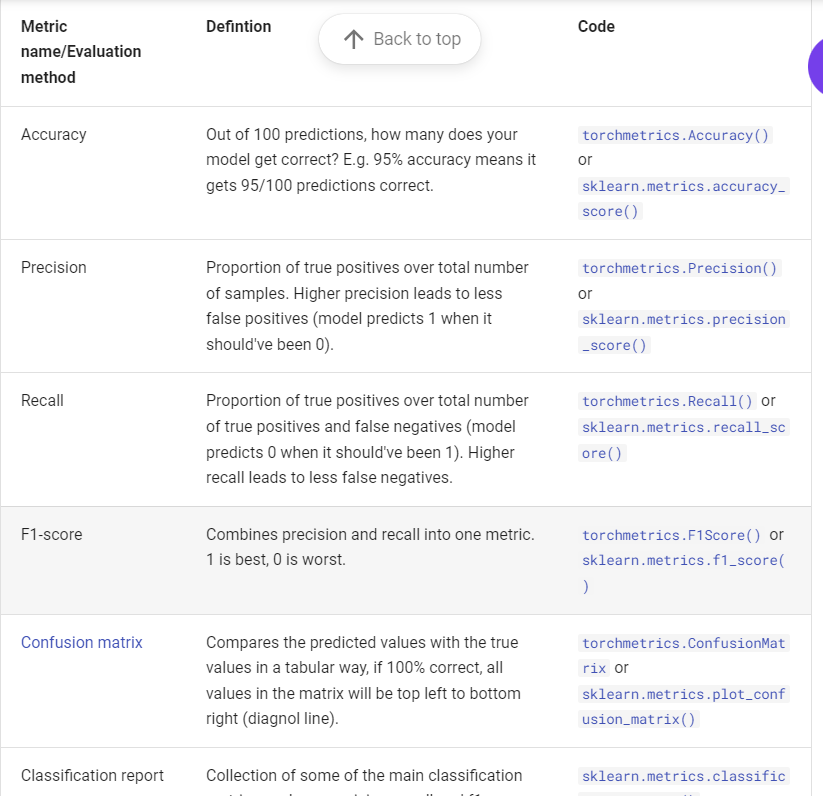

In [65]:
#we can also use like torchmetrics and all to use from it or scikit learn also
#see original notebook

In [66]:
#see the exercise solution notebook for a more complex data also